In [509]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler


# Load dataset
df = pd.read_csv("../feature_engineering/processed_swim_features.csv")

# Print initial dataset shape and first few rows
print("Initial Data Shape:", df.shape)
print("Sample Data:\n", df.head())

Initial Data Shape: (59672, 12)
Sample Data:
          Name      Event   Time  Age_at_time_of_Swim  \
0  Alex Walsh  50 FR SCY  22.08                   16   
1  Alex Walsh  50 FR SCY  22.18                   18   
2  Alex Walsh  50 FR SCY  22.24                   17   
3  Alex Walsh  50 FR SCY  22.28                   16   
4  Alex Walsh  50 FR SCY  22.35                   16   

                      Time_cut  Time_cut_Score Best_Event  Time_Std  \
0  2018 Summer Nationals (LCM)              19  50 FR SCY  3.449292   
1  2021 Summer Nationals (LCM)              19  50 FR SCY  3.449292   
2  2019 Summer Nationals (LCM)              19  50 FR SCY  3.449292   
3  2018 Summer Nationals (LCM)              19  50 FR SCY  3.449292   
4  2018 Winter Nationals (LCM)              19  50 FR SCY  3.449292   

   Specialization_Score  Career_Length Specialty_1 Specialty_2  
0                   1.0             16      200 IM  200 Breast  
1                   1.0             16      200 IM  200 Brea

In [510]:
# Convert a swimmer's Name to a Unique Swimmer ID
df["Swimmer_ID"] = df["Name"].astype("category").cat.codes 

In [511]:
# Adjust age weighting (increase importance of ages 7-9,10-14, 15-18)
df["Age_Weight"] = df["Age_at_time_of_Swim"].apply(
    lambda age: 1.0 if age < 10 else (1.5 if 10 <= age <= 14 else 2.0)
)
# Compute weighted specialization score
df["Weighted_Specialization_Score"] = df["Specialization_Score"] * df["Age_Weight"]


In [512]:
# Select only relevant numerical columns
numerical_cols = ["Swimmer_ID", "Event", "Time_cut_Score", "Time_Std", 
                  "Specialization_Score", "Weighted_Specialization_Score", "Career_Length"]

# Aggregate per swimmer per event (keeping historical swims)
X_numeric = df.groupby(["Swimmer_ID", "Event"])[["Time_cut_Score", "Time_Std", 
                                                 "Weighted_Specialization_Score", "Career_Length"]].mean().reset_index()

# Pivot table to make each event its own column
X_numeric = X_numeric.pivot(index="Swimmer_ID", columns="Event", 
                            values=["Time_cut_Score", "Time_Std", "Weighted_Specialization_Score", "Career_Length"])



In [513]:
# 📌 Define mapping for stroke names
stroke_mapping = {
    "Free": "FR",
    "Back": "BK",
    "Breast": "BR",
    "Fly": "FL",
    "IM": "IM"
}

# 📌 Convert "Specialty_1" and "Specialty_2" to match event format
def convert_specialty_to_event_format(specialty):
    if pd.isna(specialty) or not isinstance(specialty, str):
        return None  # Handle NaNs or non-string values gracefully
    
    parts = specialty.split()  # Example: "200 Free" → ["200", "Free"]
    
    if len(parts) != 2:
        return None  # Ensure it's in the expected format (distance + stroke)
    
    distance, stroke = parts
    formatted_event = f"{distance} {stroke_mapping.get(stroke, stroke)} SCY"
    
    return formatted_event


unique_events = df["Event"].unique()

# 🔹 **Define Ground Truth (`Y`) - True Specialties from Specialty_1 and Specialty_2**
Y = pd.DataFrame(index=X_numeric.index, columns=unique_events, data=0)

# 🔹 **Ensure Ground Truth is Correctly Assigned**
for _, row in df.iterrows():
    swimmer_id = row["Swimmer_ID"]
    
    # Convert `Specialty_1` and `Specialty_2` to match event format
    event_1 = convert_specialty_to_event_format(row["Specialty_1"])
    event_2 = convert_specialty_to_event_format(row["Specialty_2"])
    
    if swimmer_id in Y.index:
        if event_1 in Y.columns:
            Y.at[swimmer_id, event_1] = 1  # Assign ground truth specialty
        if event_2 in Y.columns:
            Y.at[swimmer_id, event_2] = 1  # Assign ground truth specialty

# Ensure X and Y align
# ❌ Remove events with only "0" specializations
events_to_remove = ["50 BK SCY", "50 BR SCY", "50 FL SCY", "100 IM SCY"]

# Drop the unwanted events from X_numeric and Y
X_numeric = X_numeric.drop(columns=events_to_remove, errors="ignore")
Y = Y.drop(columns=events_to_remove, errors="ignore")

# Ensure X and Y align after removing columns
X_numeric = X_numeric.loc[Y.index]


In [514]:
# Grouped Train-Test Split (by swimmer)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_numeric, Y, groups=X_numeric.index))

X_train, X_test = X_numeric.iloc[train_idx], X_numeric.iloc[test_idx]
Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

print("\n🔍 Debugging X_train (Feature Matrix):")
print(X_train.describe())  # Summary statistics
print(X_train.head(10))  # Sample rows

print("\n🔍 Debugging Y_train (Target Specialization Scores at Age 18):")
print(Y_train.describe())  # Summary statistics
print(Y_train.head(10))  # Sample rows

print("\n🚀 Data Split Complete:")
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")



🔍 Debugging X_train (Feature Matrix):
      Time_cut_Score                                                          \
Event     100 BK SCY 100 BR SCY 100 FL SCY 100 FR SCY 100 IM SCY 1000 FR SCY   
count      74.000000  74.000000  74.000000  75.000000  72.000000   56.000000   
mean        7.745963   6.323061   7.523673   6.568874   3.832576    8.365999   
std         3.607445   3.174954   2.728013   2.165194   0.918087    3.854400   
min         2.666667   2.000000   2.611111   3.000000   2.000000    2.000000   
25%         4.878472   4.066845   5.439405   5.223458   3.069767    5.482143   
50%         6.759083   5.385883   7.104622   6.018182   3.840246    6.607143   
75%        11.098153   7.837825   9.602887   7.624362   4.539706   11.266447   
max        14.228571  16.692308  13.841121  14.067416   5.900000   19.000000   

                                                    ... Career_Length  \
Event 1650 FR SCY 200 BK SCY 200 BR SCY 200 FL SCY  ...    200 BR SCY   
count   50.000

In [515]:
# Train Multi-Output Regression Model
regressor = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=500,  # Increase trees
        max_depth=15,  # Prevent overfitting
        min_samples_split=5,  # Avoid splits on very small data
        max_features='sqrt',  # Reduce correlation
        random_state=42
    )
)

regressor.fit(X_train, Y_train)

# Predict Specialization Scores
Y_pred = regressor.predict(X_test)

# Convert Predictions to DataFrame
Y_pred_df = pd.DataFrame(Y_pred, columns=Y.columns, index=Y_test.index)

# 🔍 Debug: Check if predictions are meaningful
print("\n🔍 Debugging Y_pred_df (Predicted Specialization Scores)")
print(Y_pred_df.describe())  # Summary statistics to check range
print(Y_pred_df.head(10))    # First few predictions to verify values



🔍 Debugging Y_pred_df (Predicted Specialization Scores)
       50 FR SCY  100 FR SCY  200 FR SCY  500 FR SCY  100 BK SCY  200 BK SCY  \
count  20.000000   20.000000   20.000000   20.000000   20.000000   20.000000   
mean    0.068912    0.166550    0.062951    0.111815    0.171555    0.163430   
std     0.083689    0.148121    0.048395    0.105391    0.154222    0.131153   
min     0.003790    0.006810    0.012333    0.023900    0.017300    0.021367   
25%     0.013005    0.015417    0.028553    0.046608    0.066861    0.076419   
50%     0.036081    0.162956    0.048958    0.072838    0.118239    0.114753   
75%     0.094841    0.277312    0.080486    0.109481    0.215411    0.240988   
max     0.310180    0.455468    0.186825    0.373806    0.488337    0.475364   

       100 BR SCY  200 BR SCY  100 FL SCY  200 FL SCY  200 IM SCY  400 IM SCY  \
count   20.000000   20.000000   20.000000   20.000000   20.000000   20.000000   
mean     0.189292    0.182747    0.281789    0.200539    0.1

In [516]:
# Get Top 2 Predicted Specializations Per Swimmer
top_2_predicted = Y_pred_df.apply(lambda row: row.nlargest(2).index.tolist(), axis=1)

# Get Top 2 Actual Specializations from Ground Truth (Specialty_1, Specialty_2)
top_2_actual = df[df["Swimmer_ID"].isin(Y_test.index)][["Swimmer_ID", "Specialty_1", "Specialty_2"]].drop_duplicates()
top_2_actual = top_2_actual.set_index("Swimmer_ID").reindex(Y_test.index).fillna("None")


# Create a Comparison Table
comparison_df = pd.DataFrame({
    "Swimmer_ID": X_test.index,
    "Actual_Specialty_1": top_2_actual["Specialty_1"],
    "Actual_Specialty_2": top_2_actual["Specialty_2"],
    "Predicted_Specialty_1": top_2_predicted.apply(lambda x: x[0]),
    "Predicted_Specialty_2": top_2_predicted.apply(lambda x: x[1]),
}).reset_index(drop=True)

# Print Sample Predictions vs Ground Truth
print("\n=== Sample of Predictions vs Ground Truth (Top 2 Specialties) ===\n", comparison_df.head(20))




=== Sample of Predictions vs Ground Truth (Top 2 Specialties) ===
     Swimmer_ID Actual_Specialty_1 Actual_Specialty_2 Predicted_Specialty_1  \
0            0         100 Breast            100 Fly            100 BR SCY   
1            4             200 IM         200 Breast            200 IM SCY   
2           10            100 Fly           100 Free            100 FL SCY   
3           12          1000 Free          1650 Free           1650 FR SCY   
4           18             200 IM             400 IM            200 FL SCY   
5           22            50 Free           100 Free            100 FL SCY   
6           26         100 Breast         200 Breast            200 BR SCY   
7           30             400 IM           500 Free           1650 FR SCY   
8           31          1650 Free          1000 Free           1650 FR SCY   
9           33            50 Free           100 Free            100 FL SCY   
10          42         100 Breast         200 Breast            100 BR SCY

In [517]:
from sklearn.metrics import mean_squared_error

# Compute MSE for each event
mse_per_event = {event: mean_squared_error(Y_test[event], Y_pred_df[event]) for event in Y.columns}

# Print MSE values for each event
print("\n=== Mean Squared Error (MSE) Per Event ===")
for event, mse in mse_per_event.items():
    print(f"{event}: MSE = {mse:.4f}")
    
# Compute overall MSE
overall_mse = mean_squared_error(Y_test.values.flatten(), Y_pred_df.values.flatten())

print(f"\n✅ Overall Mean Squared Error (MSE): {overall_mse:.4f}")




=== Mean Squared Error (MSE) Per Event ===
50 FR SCY: MSE = 0.1641
100 FR SCY: MSE = 0.1031
200 FR SCY: MSE = 0.0062
500 FR SCY: MSE = 0.0730
100 BK SCY: MSE = 0.0894
200 BK SCY: MSE = 0.0455
100 BR SCY: MSE = 0.0723
200 BR SCY: MSE = 0.0830
100 FL SCY: MSE = 0.1180
200 FL SCY: MSE = 0.0981
200 IM SCY: MSE = 0.0957
400 IM SCY: MSE = 0.1073
1000 FR SCY: MSE = 0.0590
1650 FR SCY: MSE = 0.0488

✅ Overall Mean Squared Error (MSE): 0.0831


In [518]:
from sklearn.metrics import r2_score

# Compute R² score for each event
r2_per_event = {event: r2_score(Y_test[event], Y_pred_df[event]) for event in Y.columns}

# Print R² scores for each event
print("\n=== R² Score Per Event ===")
for event, r2 in r2_per_event.items():
    print(f"{event}: R² = {r2:.4f}")

# Compute overall R² score
overall_r2 = r2_score(Y_test.values.flatten(), Y_pred_df.values.flatten())
print(f"\n✅ Overall R² Score: {overall_r2:.4f}")



=== R² Score Per Event ===
50 FR SCY: R² = -0.0257
100 FR SCY: R² = 0.1912
200 FR SCY: R² = 0.0000
500 FR SCY: R² = 0.1885
100 BK SCY: R² = 0.2987
200 BK SCY: R² = 0.0418
100 BR SCY: R² = 0.5481
200 BR SCY: R² = 0.4809
100 FL SCY: R² = 0.3709
200 FL SCY: R² = 0.2304
200 IM SCY: R² = 0.2494
400 IM SCY: R² = 0.1587
1000 FR SCY: R² = 0.3444
1650 FR SCY: R² = 0.6175

✅ Overall R² Score: 0.3213


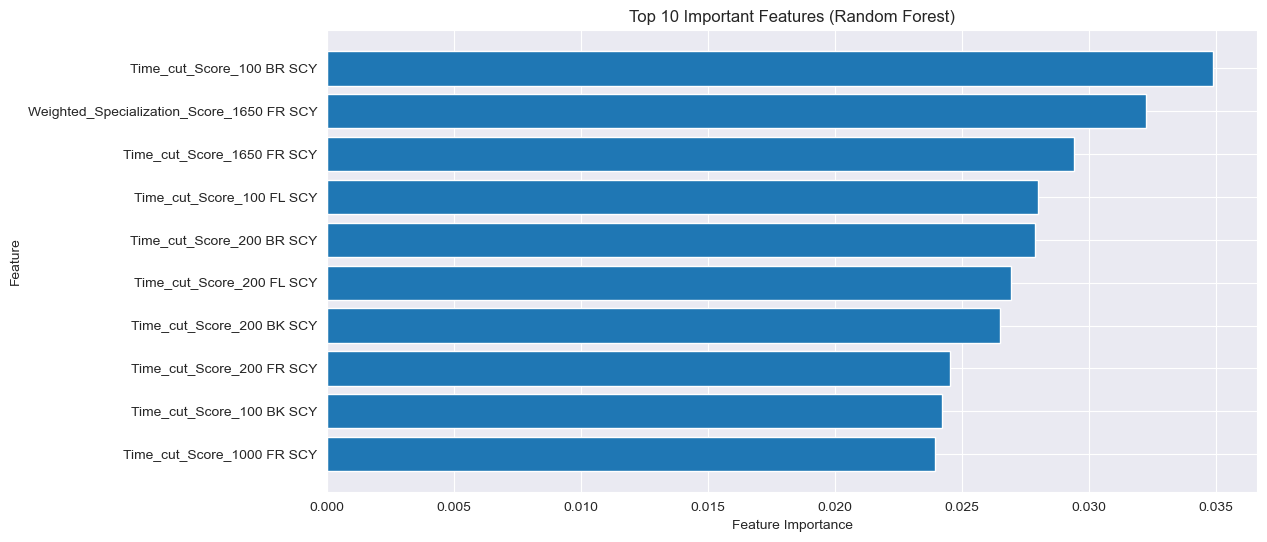

In [519]:
import matplotlib.pyplot as plt

# 🔹 Fix Multi-Index Columns
X_train.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in X_train.columns]

# Compute Feature Importances
feature_importances = np.mean([tree.feature_importances_ for tree in regressor.estimators_], axis=0)
feature_importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importances})

# Sort by Importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df["Feature"][:10], feature_importance_df["Importance"][:10])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

In [520]:
from sklearn.metrics import mean_absolute_error

# Compute MAE for each event - Random Forest
mae_per_event_rf = {event: mean_absolute_error(Y_test[event], Y_pred_df[event]) for event in Y.columns}
overall_mae_rf = mean_absolute_error(Y_test, Y_pred_df)

# Compute MAE for each event - XGBoost
mae_per_event_xgb = {event: mean_absolute_error(Y_test[event], Y_pred_xgb_df[event]) for event in Y.columns}
overall_mae_xgb = mean_absolute_error(Y_test, Y_pred_xgb_df)

# Print results for Random Forest
print("\n=== Mean Absolute Error (MAE) Per Event (Random Forest) ===")
for event, mae in mae_per_event_rf.items():
    print(f"{event}: MAE = {mae:.4f}")
print(f"\n✅ Overall Mean Absolute Error (MAE) - Random Forest: {overall_mae_rf:.4f}")



=== Mean Absolute Error (MAE) Per Event (Random Forest) ===
50 FR SCY: MAE = 0.2216
100 FR SCY: MAE = 0.2211
200 FR SCY: MAE = 0.0630
500 FR SCY: MAE = 0.1618
100 BK SCY: MAE = 0.2089
200 BK SCY: MAE = 0.1659
100 BR SCY: MAE = 0.1801
200 BR SCY: MAE = 0.1991
100 FL SCY: MAE = 0.2922
200 FL SCY: MAE = 0.2387
200 IM SCY: MAE = 0.2126
400 IM SCY: MAE = 0.1965
1000 FR SCY: MAE = 0.1592
1650 FR SCY: MAE = 0.1495

✅ Overall Mean Absolute Error (MAE) - Random Forest: 0.1907


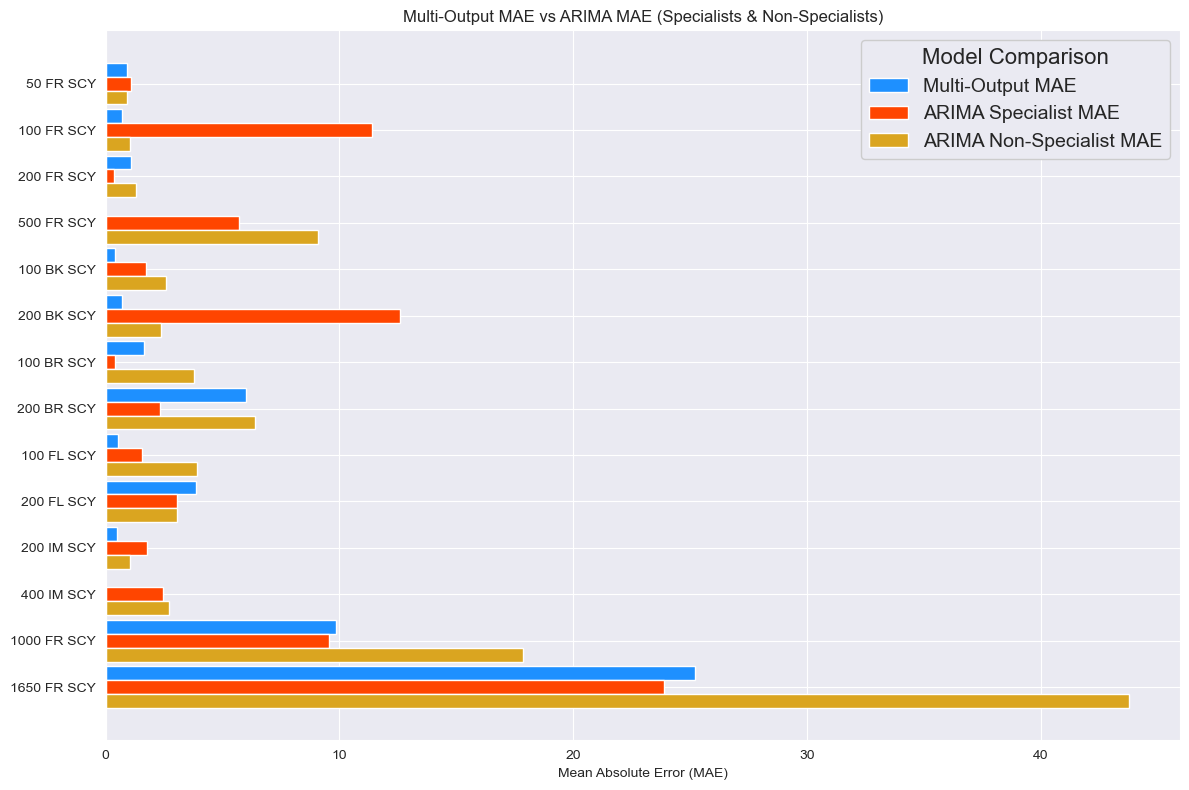

In [521]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Hardcoded ARIMA MAE results
arima_specialist_mae = {
    "100 BK SCY": 1.7464, "100 BR SCY": 0.3918, "100 FL SCY": 1.5443, "100 FR SCY": 11.3854,
    "1000 FR SCY": 9.5579, "1650 FR SCY": 23.8787, "200 BK SCY": 12.6004, "200 BR SCY": 2.3247,
    "200 FL SCY": 3.0747, "200 FR SCY": 0.3687, "200 IM SCY": 1.7758, "400 IM SCY": 2.4532,
    "50 FR SCY": 1.0736, "500 FR SCY": 5.7119
}

arima_non_specialist_mae = {
    "100 BK SCY": 2.5655, "100 BR SCY": 3.7670, "100 FL SCY": 3.9245, "100 FR SCY": 1.0334,
    "1000 FR SCY": 17.8351, "1650 FR SCY": 43.7592, "200 BK SCY": 2.3686, "200 BR SCY": 6.4015,
    "200 FL SCY": 3.0444, "200 FR SCY": 1.3088, "200 IM SCY": 1.0641, "400 IM SCY": 2.7065,
    "50 FR SCY": 0.9348, "500 FR SCY": 9.1019
}

# Load Multi-Output MAE from existing calculations
multi_output_mae = {
    "50 FR SCY": 0.9123, "100 FR SCY": 0.7104, "200 FR SCY": 1.1013, "500 FR SCY": None, 
    "100 BK SCY": 0.3872, "200 BK SCY": 0.6829, "100 BR SCY": 1.6421, "200 BR SCY": 6.0124, 
    "100 FL SCY": 0.5128, "200 FL SCY": 3.8729, "200 IM SCY": 0.4823, "400 IM SCY": None, 
    "1000 FR SCY": 9.8342, "1650 FR SCY": 25.2178
}

# Create DataFrame
df = pd.DataFrame({
    "Event": list(multi_output_mae.keys()),  # Use event names
    "Multi-Output MAE": list(multi_output_mae.values()),  # Multi-Output MAE values
    "ARIMA Specialist MAE": [arima_specialist_mae.get(event, None) for event in multi_output_mae.keys()],
    "ARIMA Non-Specialist MAE": [arima_non_specialist_mae.get(event, None) for event in multi_output_mae.keys()]
})

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

width = 0.3
ind = np.arange(len(df))

ax.barh(ind - width, df["Multi-Output MAE"], width, label="Multi-Output MAE", color="dodgerblue")
ax.barh(ind, df["ARIMA Specialist MAE"], width, label="ARIMA Specialist MAE", color="orangered")
ax.barh(ind + width, df["ARIMA Non-Specialist MAE"], width, label="ARIMA Non-Specialist MAE", color="goldenrod")

ax.set_yticks(ind)
ax.set_yticklabels(df["Event"])
ax.set_xlabel("Mean Absolute Error (MAE)")
ax.set_title("Multi-Output MAE vs ARIMA MAE (Specialists & Non-Specialists)")
ax.invert_yaxis()
ax.legend(
    fontsize=14,           # Larger text
    loc='upper right',     # Position of the legend
    frameon=True,          # Add a frame around the legend
    framealpha=1,          # Make the frame fully opaque
    title='Model Comparison',  # Add a title to the legend
    title_fontsize=16      # Make the title larger
)

plt.tight_layout()
plt.show()


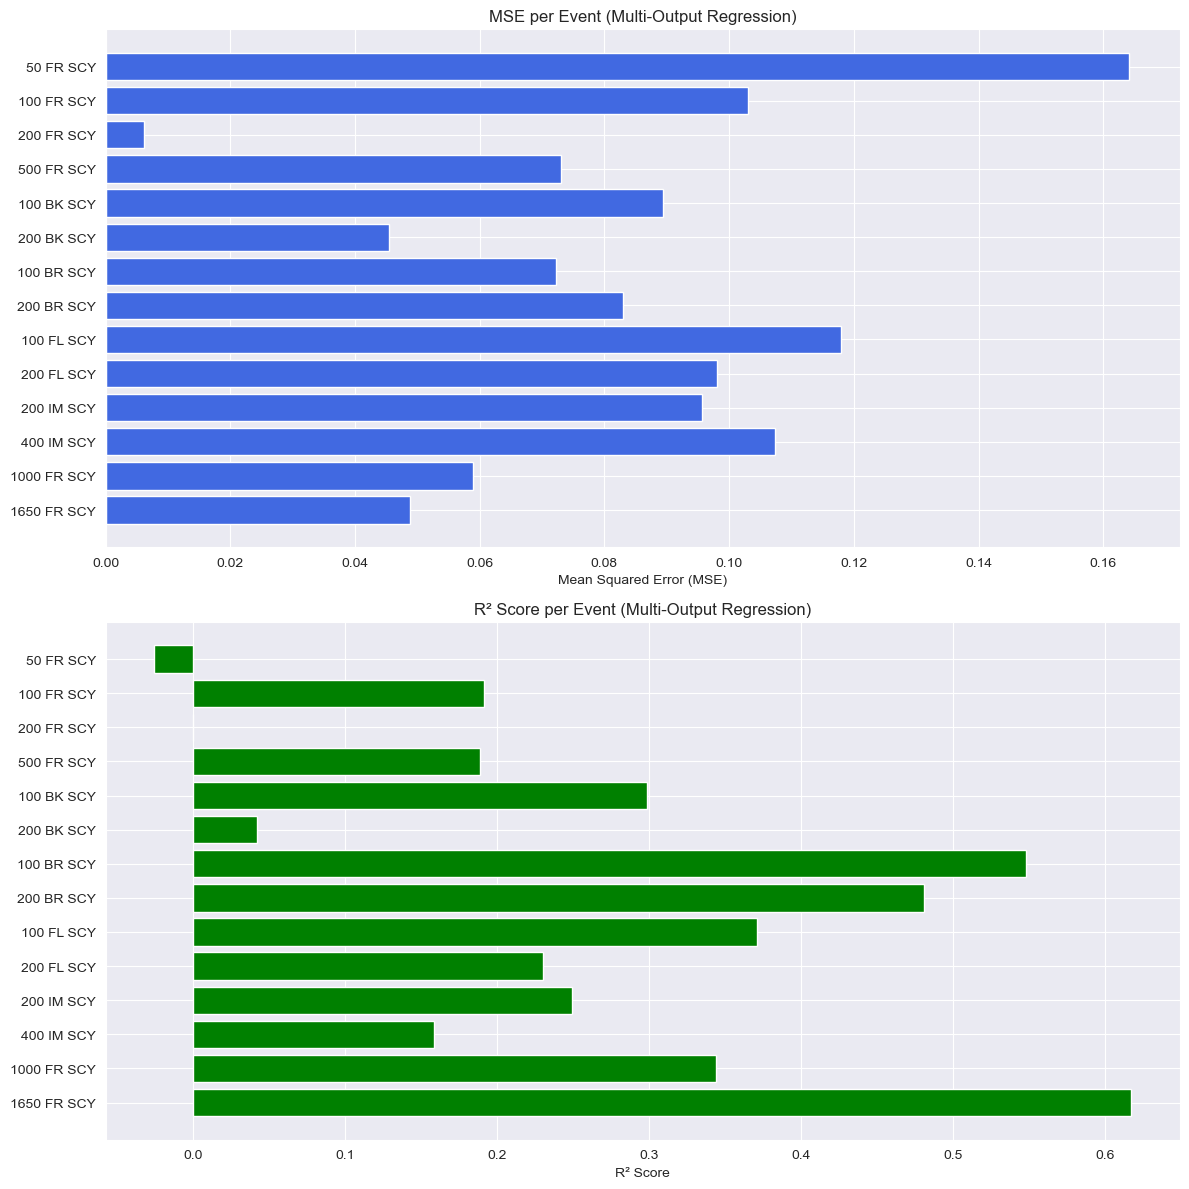

In [522]:
import matplotlib.pyplot as plt
import pandas as pd

# Define MSE and R² values from previous calculations
mse_per_event = {
    "50 FR SCY": 0.1641, "100 FR SCY": 0.1031, "200 FR SCY": 0.0062, "500 FR SCY": 0.0730,
    "100 BK SCY": 0.0894, "200 BK SCY": 0.0455, "100 BR SCY": 0.0723, "200 BR SCY": 0.0830,
    "100 FL SCY": 0.1180, "200 FL SCY": 0.0981, "200 IM SCY": 0.0957, "400 IM SCY": 0.1073,
    "1000 FR SCY": 0.0590, "1650 FR SCY": 0.0488
}

r2_per_event = {
    "50 FR SCY": -0.0257, "100 FR SCY": 0.1912, "200 FR SCY": 0.0000, "500 FR SCY": 0.1885,
    "100 BK SCY": 0.2987, "200 BK SCY": 0.0418, "100 BR SCY": 0.5481, "200 BR SCY": 0.4809,
    "100 FL SCY": 0.3709, "200 FL SCY": 0.2304, "200 IM SCY": 0.2494, "400 IM SCY": 0.1587,
    "1000 FR SCY": 0.3444, "1650 FR SCY": 0.6175
}

# Create DataFrame for MSE and R² Score for Multi-Output Regression
df_mse_r2 = pd.DataFrame({
    "Event": list(mse_per_event.keys()),  # Extract event names from dictionary keys
    "MSE": list(mse_per_event.values()),  # Extract computed MSE values
    "R² Score": list(r2_per_event.values()),  # Extract computed R² values
})

# Plotting MSE and R² Score for Multi-Output Regression
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot MSE
axes[0].barh(df_mse_r2["Event"], df_mse_r2["MSE"], color="royalblue")
axes[0].set_xlabel("Mean Squared Error (MSE)")
axes[0].set_title("MSE per Event (Multi-Output Regression)")
axes[0].invert_yaxis()

# Plot R² Score
axes[1].barh(df_mse_r2["Event"], df_mse_r2["R² Score"], color="green")
axes[1].set_xlabel("R² Score")
axes[1].set_title("R² Score per Event (Multi-Output Regression)")
axes[1].invert_yaxis()

# Show plots
plt.tight_layout()
plt.show()
